<a href="https://colab.research.google.com/github/snehahs03/medical-image-analysis/blob/main/Copy_of_success2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
%cd /content/drive/MyDrive/medical-image-analysis

/content/drive/MyDrive/medical-image-analysis


In [5]:
!git clone https://github.com/snehahs03/medical-image-analysis.git

fatal: destination path 'medical-image-analysis' already exists and is not an empty directory.


In [6]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications.densenet import DenseNet201
%matplotlib inline
import matplotlib.pyplot as plt

import json
import math
import cv2
from PIL import Image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import Sequential
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools

In [7]:
data_dir = '/content/drive/MyDrive/medical-image-analysis/medical-image-analysis/train'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 4004 files belonging to 5 classes.


In [8]:
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2)

In [9]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [10]:
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 3204 images belonging to 5 classes.
Found 800 images belonging to 5 classes.


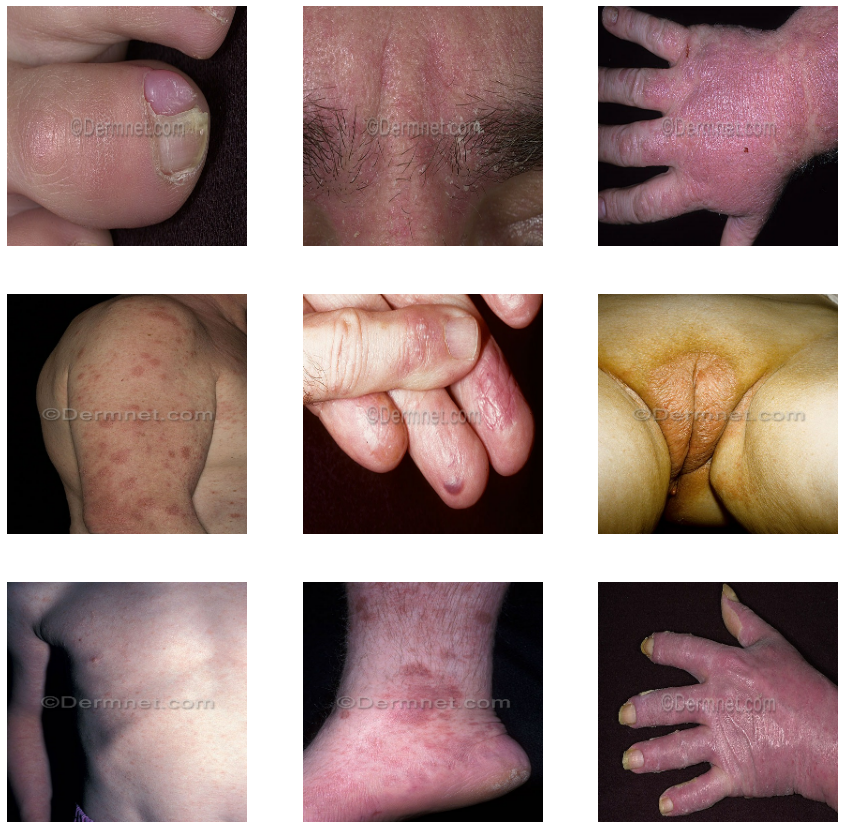

In [11]:
def show_img(data):
    plt.figure(figsize=(15,15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(data)

In [12]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [13]:
num_classes = len(data.class_names)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
x = pre_trained.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = pre_trained.input, outputs = predictions)
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

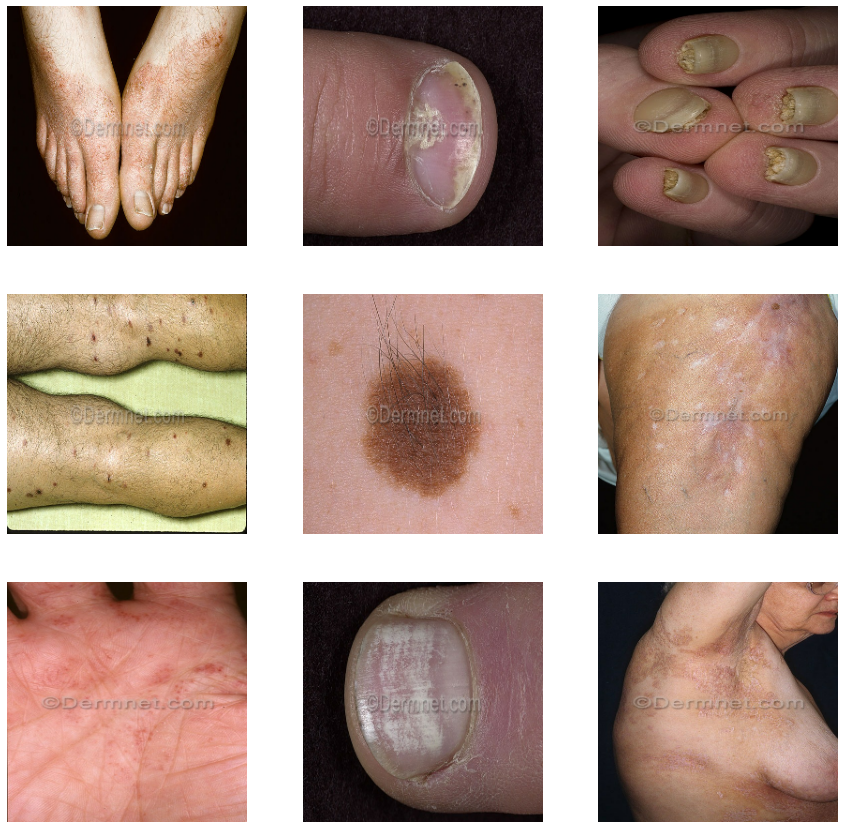

In [14]:
def show_img(data):
    plt.figure(figsize=(15,15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(data)

In [15]:
model.summary()
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size

history = model.fit_generator(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 35,
                    verbose = 1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 228, 228, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 113, 113, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/35
100/100 [==============================] - 1744s 17s/step - loss: 1.7396 - accuracy: 0.5735 - val_loss: 1.5623 - val_accuracy: 0.4975
Epoch 2/35
100/100 [==============================] - 72s 723ms/step - loss: 1.1183 - accuracy: 0.6346 - val_loss: 1.5951 - val_accuracy: 0.5437
Epoch 3/35
100/100 [==============================] - 73s 728ms/step - loss: 0.9530 - accuracy: 0.6554 - val_loss: 1.4393 - val_accuracy: 0.5475
Epoch 4/35
100/100 [==============================] - 72s 721ms/step - loss: 0.8473 - accuracy: 0.6620 - val_loss: 1.3608 - val_accuracy: 0.5650
Epoch 5/35
100/100 [==============================] - 73s 731ms/step - loss: 0.7947 - accuracy: 0.6803 - val_loss: 1.5231 - val_accuracy: 0.5437
Epoch 6/35
100/100 [==============================] - 74s 743ms/step - loss: 0.7183 - accuracy: 0.7115 - val_loss: 1.3999 - val_accuracy: 0.5675
Epoch 7/35
100/100 [==============================] - 78s 778ms/step - loss: 0.7029 - accuracy: 0.7144 - val_loss: 1.6270 - val_ac

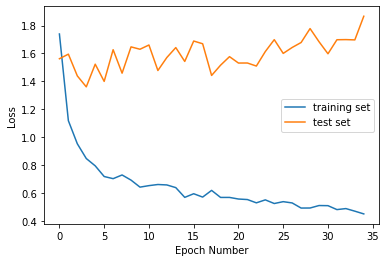

In [16]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

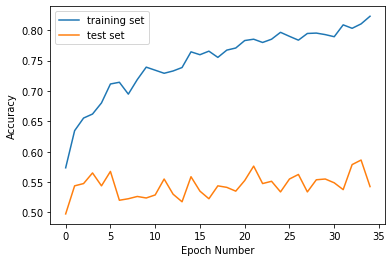

In [17]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [ ]:
model_name = 'img_recognition_inceptionV3.h5'
model.save(model_name, save_format='h5')

In [24]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

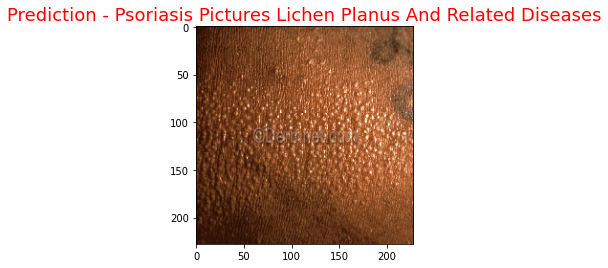

In [29]:
from tensorflow.keras.preprocessing import image
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)
predict_image('/content/drive/MyDrive/medical-image-analysis//medical-image-analysis/images/psoriasis2.jpg', model)

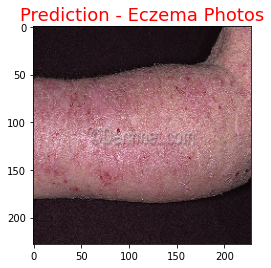

In [26]:
predict_image('/content/drive/MyDrive/medical-image-analysis//medical-image-analysis/images/eczema1.jpg', model)

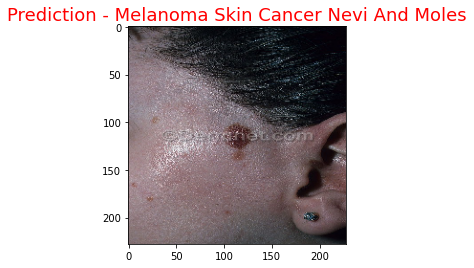

In [27]:
predict_image('/content/drive/MyDrive/medical-image-analysis//medical-image-analysis/images/melanoma1.jpg', model)

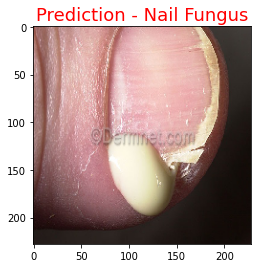

In [28]:
predict_image('/content/drive/MyDrive/medical-image-analysis/medical-image-analysis/images/acute-paronychia-12.jpg', model)

In [30]:
!git config --global user.email "hssneha03@gmail.com"

In [31]:
!git config --global user.name "snehahs03"